In [363]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import random
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from IPython.display import clear_output

import numpy as np
from tensorflow import keras
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing
tfd = tfp.distributions

import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten

Num GPUs Available:  1


In [364]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [365]:
# 1 Initialization
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import matplotlib.colors as c
from pylatex import Document, Section, Subsection, Tabular, Math, TikZ, Axis, \
    Plot, Figure, Matrix, Alignat
from pylatex.utils import italic
import os
import mpmath
from astropy.io import fits
from datetime import datetime
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from IPython.display import clear_output

In [366]:
# 2 Important Parameters
observingLatitudeDegrees = 20 # Observing latitude - Default : 35
viewLength = 3e17 # Length of the display box - Default : 6e17
distanceLY = 8000 # Distance to the lebula in light years 
resolution = 500 # Number of pixels of one side of the display - Default : 200
distance_steps = 6000 # Number of distance steps in the optical depth center array - Default : 3000
angle_steps = 3600 # Number of angle steps in the optical depth center array - Default : 1800
absorptionSteps_center = 10 # Number of steps between two adjacent elements of the spherical optical depth array - Default : 10
absorptionSteps = 5 # Number of steps between two adjacent elements in the cubical optical depth array - Default : 5
starRadius = 7e11 # Radius of the central star, used to determine the flux arriving at earth

In [367]:
# 3 Nebula Shape Parameters
# Basic shape properties of the nebula
Rin = 1e16 # Inner cavity radius - Default : 1e16
power = 2 # Density inverse relation to radius - Default : 2
density_enhancement = 20 # Density enhancement factor - Default : 7
edge_thickness = 0.12
focus = 9e15-1e16
directrix = -1.55e16-1e16
eccentricity = 0.85

In [368]:
# 4 Nebula Content Parameters
# Mass properties of the nebula
# Luminosity_Solar_Luminosity = 1 # Luminosity of the central star in Solar Luminosity
# Luminosity = Luminosity_Solar_Luminosity*3.83e26 # Luminosity of the central star in Watts
Mdot_Solar_Mass = 1e-5 # Mass loss rate of all molecules in solar masses - Default : 1e-5
Mdot = Mdot_Solar_Mass*2e33/(365*24*60*60) # Mass loss rate of all molecules in g/seconds
particle_radius = 1e-5 # cm - Default : 1e-5 / smaller
wavelength = 5e-5 # cm - Default : 5e-5
albedo = 0.5
scattering_effective_crosssection = (np.pi*particle_radius**2)*2*np.pi*(particle_radius/(wavelength)) # Per grain per cm^2
dust_to_gas = 1/200 # Dust to gas ratio - Default : 1/200
grain_mass = 1.3e-14 # Mass of the individual grain in grams - Default : 1.3e-14
asymmetry_constant = 0.5 # The scattering asymmetry constant - Default : 0.5

In [369]:
# 5 Pre-compute Important Numbers
observingLatitude = np.pi*(observingLatitudeDegrees/180) # The latitude the observer is currently at in radians
sin = np.sin(observingLatitude) # precompute the trigs of the observer
cos = np.cos(observingLatitude)
viewSize = viewLength/2 # Half the size of the picture
angularSize = viewSize/(distanceLY/2.18e-13)
FD = focus - directrix
center = focus + FD*eccentricity**2/(1-eccentricity**2)
focus_2 = center - (center - focus)*(1 - edge_thickness)
directrix_2 = center - (center - directrix)*(1 - edge_thickness)

In [370]:
# 6 Logistic functions
def norm(x):
    return np.sqrt(x[0]**2+x[1]**2+x[2]**2)
  # norm(): returns the norm of a given vector x (the vector is in the form of np.array([x,y,z]))

def vector_angle(v1,v2):
    norm1 = norm(v1)
    norm2 = norm(v2)
    if norm1==0 or norm2==0:
        return 0
    else:
        factor = np.dot(v1,v2)/(norm1*norm2)
        if factor > 1:
            return 0
        elif factor < -1:
            return np.pi
        else:
            return np.arccos(factor)
    # vector_angle(): returns the angle between two cartesian vectors

def spherical_to_cartesian(r):
    sin_cur=np.sin(r[1])
    return np.array([r[0]*sin_cur*np.cos(r[2]),r[0]*sin_cur*np.sin(r[2]),r[0]*np.cos(r[1])])
  # spherical_to_cartesian(): returns the cartesian representation of the given spherical vector r
  # the cartesian vector x is defined in the refernce frame of nebula, not the observer

def cartesian_to_spherical(x):
    norm = np.sqrt(x[0]**2+x[1]**2+x[2]**2) # pre compute the norm of the vector
    if norm==0:
        return np.array([0,0,0])
    elif x[0]==0:
        return np.array([norm,np.arccos(x[2]/norm),np.pi/2])
    else:
        return np.array([norm,np.arccos(x[2]/norm),np.arctan(x[1]/x[0])])
    # cartesian_to_spherical(): returns the spherical representation of the cartesian vector x
    # the cartesian vector x is defined in the reference frame of nebula, not the observer

In [371]:
# 7 Scattering Phase Function
def phase_function(angle): # Henyey-Greenstein
    return 1/(4*np.pi)*(1 - asymmetry_constant**2)/((1 + asymmetry_constant**2 - 2*asymmetry_constant*np.cos(angle))**(3/2))

In [372]:
# 8 Detailed Shape of the Nebula
def lobe(latitude,distance): #both must be positive absolute values
    sin_lat = np.abs(np.sin(latitude))
    pf = np.sqrt(distance**2+focus**2-2*distance*focus*sin_lat) # law of cosines
    pd = distance*sin_lat - directrix
    parabola_factor = np.abs(pf/pd)
    pf_2 = np.sqrt(distance**2+focus_2**2-2*distance*focus_2*sin_lat) # law of cosines
    pd_2 = distance*sin_lat - directrix_2
    parabola_factor_2 = np.abs(pf_2/pd_2)
    if parabola_factor<eccentricity:
        if parabola_factor_2<eccentricity:
            return 1
        return 2
    else:
        return 0

def density(latitude,distance):
    if distance < Rin/2:
        return 0
    sin_lat = np.abs(np.sin(latitude))
    lat = np.abs(latitude/np.pi*2)
    if lobe(latitude,distance)==1:
        velocity = 2e7
        dr_cur = 1.05e16 # sharpness of the cutoff/cutoff length, unit in cm
        if lat>=85/90:
            R_cur = 1e17#1.87e+17 # cutoff radius, unit in cm
        else:
            R_cur = 1.6e17#1.87e+17 # cutoff radius, unit in cm
    elif lobe(latitude,distance)==2:
        velocity = 2e7/density_enhancement
        dr_cur = 1.05e16 # sharpness of the cutoff/cutoff length, unit in cm
        if lat>=85/90:
            velocity = 2e7
            R_cur = 1e17#1.87e+17 # cutoff radius, unit in cm
        else:
            R_cur = 1.87e17 # cutoff radius, unit in cm
    else: # disk(x_cur,y_cur)==1: # Disk
        velocity = 1e6+1e6*np.abs(sin_lat)
        dr_cur = 3e15
        R_cur = 6e16
        
    cutoff_outer = 0.5*(1 - np.tanh((distance-R_cur)/dr_cur))
    cutoff_inner = 0.5*(1 - np.tanh((Rin-distance)/(Rin/10)))
    
    return (dust_to_gas*Mdot/grain_mass)*(cutoff_outer*cutoff_inner)/(4*np.pi*(distance**power)*velocity)
def density_cartesian(x):
    spherical = cartesian_to_spherical(x) # x in spherical coordinates
    return density(np.pi/2-spherical[1],spherical[0])

In [373]:
# 9 Density Display Function
@np.vectorize
def density_map(x,y):
    return density_cartesian(np.array([0,y,-x]))#**(1/float(5))
# Density display, density scales by the power of 1/5

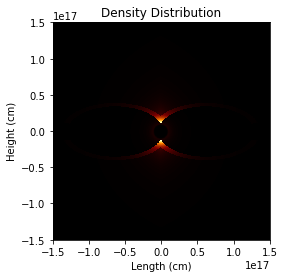

In [374]:
# 10 Density Display
side = np.linspace(-viewSize,viewSize,2*resolution+1)
x,y = np.meshgrid(side,side)
Value = density_map(x,y)
plt.xlabel("Length (cm)")
plt.ylabel("Height (cm)")
plt.title("Density Distribution")
plt.pcolormesh(x,y,Value,cmap='afmhot',shading='auto')
plt.gca().set_aspect('equal')

total_mass = 0.0
x = -viewSize
y = -viewSize
z = -viewSize
while x <= viewSize:
    y = -viewSize
    while y <= viewSize:
        z = -viewSize
        while z <= viewSize:
            total_mass = total_mass + density_cartesian(np.array([x,y,z]))
            z += 1e16
        y += 1e16
    x += 1e16
total_mass = total_mass*48*1e48*grain_mass
print(total_mass)

In [375]:
# 11 Array Coordinate - Skyplane Coordinate Translations
def coord_to_index(x,y): 
    # coord_to_index(): Returns the array index i given the skyplane coordinates x,y in cm 
    return int(int(((x/viewSize)+1)*(resolution/2))+int((y/viewSize)*(resolution/2))*(resolution+1))
def index_to_x(i):
    # index_to_x(): Returns the skyplane coordinate x given the array index i
    return (int(i%(resolution+1))/(resolution/2)-1)*viewSize
def index_to_y(i):
    # index_to_y(): Returns the skyplane coordinate y given the array index i
    return (int(i/(resolution+1))/(resolution/2))*viewSize

In [376]:
# 12 Define Spherical Optical Depth Integration Function
def optical_depth_center_progression(latitude,distance):
    # optical_depth_center_progression(): Optical depth between two close points
    sum = 0 # total
    i = 0 # iterator
    while i < 1:
        add = density(latitude,distance+i*(viewSize/(distance_steps*absorptionSteps_center)))
        sum += add # add the non constant density
        i += 1/absorptionSteps_center
    sum = scattering_effective_crosssection*sum*(2*viewSize/(distance_steps*absorptionSteps_center)) # now multiply the constants of the integrand
    return sum/albedo # return the result

In [377]:
def optical_depth_center_real(latitude,distance):
    # optical_depth_center_progression(): Optical depth between two close points
    sum = 0 # total
    i = 1 # iterator
    while i <= 300:
        add = density(latitude,i*(distance/300))
        sum += add # add the non constant density
        i += 1
    sum = scattering_effective_crosssection*sum/300*distance # now multiply the constants of the integrand
    return sum/albedo # return the result

In [378]:
# 13 Spherical Optical Depth Array
# Define the spherical optical depth array
# i from 0 to distance_steps, represents distance from 0 to 2*viewSize
# j from 0 to pi/2, represents the latitude
i, j = distance_steps+1, angle_steps+1
optical_depth_center_array = [[0 for x in range(i)] for y in range(j)]

In [379]:
# 14 Computing The Spherical Optical Depth Array
for i in range(0,angle_steps):
    clear_output(wait=True)
    print(str(int((i*100)/(angle_steps)+1))+'%')
    for j in range(0,distance_steps):
        # For each angle, accumulatively compute the optical depth
        add = optical_depth_center_progression(i*np.pi/(2*angle_steps),j*(2*viewSize/distance_steps))
        optical_depth_center_array[i][j] = optical_depth_center_array[i][j-1] + add

100%


In [380]:
# 15 Define Cubical Optical Depth Integration Function
n = 2*viewSize/resolution
def optical_depth_progression(x1,x2):
    # optical_depth_progression(): Optical depth between two close points
    sum = 0 # total
    i = 0 # iterator
    while i < 1:
        add = density_cartesian(x1+i*(x2-x1))
        sum += add # add the non constant density
        i += 1/absorptionSteps
    sum = scattering_effective_crosssection*sum*n/absorptionSteps # now multiply the constants of the integrand
    return sum/albedo # return the result

In [381]:
# 16 Cubical Optical Depth Array
# Define the cubical optical depth array
# j is the depth, "0" is the closest to the viewplane, "resolution" isthe deepest, resolution+1 steps in total
# i is the coordinate, is the x*(resolution+1)+y, minimum 0 (x minimum, y=0), maximum (resolution+1)*(resolution)-1 (top right corner)
# here x and y are pixel coordinates, from 0 to resolution
i, j = resolution+1, (resolution+1)*(int(resolution/2)+1)
optical_depth_array = [[0 for x in range(i)] for y in range(j)]

In [382]:
# 17 Computing The Cubical Optical Depth Array
r = (resolution+1)*(int(resolution/2)+1)-1
for i in range(0,r):
    clear_output(wait=True)
    print(str(int((i*100)/r))+'%')
    for j in range(0,resolution):
        # For each coordinate, accumulate the optical depth along the line of sight
        x = index_to_x(i)
        y = index_to_y(i)
        add = optical_depth_progression(np.array([x*sin+(((resolution/2)-j)/(resolution/2)*viewSize)*cos,y,-x*cos+(((resolution/2)-j)/(resolution/2)*viewSize)*sin]),np.array([x*sin+(((resolution/2)-(j-1))/(resolution/2)*viewSize)*cos,y,-x*cos+(((resolution/2)-(j-1))/(resolution/2)*viewSize)*sin]))
        optical_depth_array[i][j] = optical_depth_array[i][j-1] + add

99%


In [383]:
# 18 Saving Data Arrays
import csv
now = datetime.now()
dt_string = now.strftime("%m_%d_%Y_%Hh%Mm%Ss")
month_string = now.strftime("%m_%Y")
if os.path.exists("Desktop/Research/"+month_string)==False:
    os.makedirs("Desktop/Research/"+month_string)
np.savetxt("Desktop/Research/"+month_string+"/_odc.csv", optical_depth_center_array, delimiter=",")
np.savetxt("Desktop/Research/"+month_string+"/_od.csv", optical_depth_array, delimiter=",")

In [384]:
# Reading Data Arrays
optical_depth_center_array = np.loadtxt("Desktop/Research/"+month_string+"/_odc.csv",skiprows=0,delimiter = ',')
optical_depth_array = np.loadtxt("Desktop/Research/"+month_string+"/_od.csv",skiprows=0,delimiter = ',')

In [385]:
# 18 Defining the Optical Intensity Function
asymmetry_constant = 0.5 # This can change with each recompute, without altering the array, mainly changing front/back ratio
scale_factor = 74 # The post-compute multiplier applied to the density/optical depth array
@np.vectorize
def intensity(x,y):
    sum = 0.0
    i = coord_to_index(x,y)
    for j in range(0,resolution):
        cur = np.array([float(x*sin+(((resolution/2)-j)/(resolution/2)*viewSize)*cos),float(y),float(-x*cos+(((resolution/2)-j)/(resolution/2)*viewSize)*sin)]) # current point (precise value stored in array)
        spherical = cartesian_to_spherical(cur) # spherical of current point, to find the optical depth center
        o_d_center = scale_factor*optical_depth_center_array[np.abs(int((angle_steps/90)*(90-(180*spherical[1]/np.pi))))][int(spherical[0]/(2*viewSize)*distance_steps)]
        o_d = scale_factor*optical_depth_array[i][j]
        add = (1/(4*np.pi*((spherical[0])**2)))*mpmath.exp(-o_d)*mpmath.exp(-o_d_center)*scale_factor*scattering_effective_crosssection*density(np.pi/2-spherical[1],spherical[0])*phase_function(vector_angle(np.array([cos,0,sin]),cur))*((2*angularSize*4.848e-6*distanceLY*9.461e17)/resolution)**3/(((2*angularSize*4.848e-6*distanceLY*9.461e17)/resolution/7e10)**2)
        if x==0 and y==0 and j == resolution/2:
            add = mpmath.exp(-scale_factor*optical_depth_array[coord_to_index(0,0)][int(j)])
        sum += add
    return sum

side = np.linspace(-viewSize,0,int(resolution/2)+1)
sideY = np.linspace(0,0,1)
x,y = np.meshgrid(side,sideY)
np.seterr(divide='ignore')
scale_factor = 65
scale_factor_step = scale_factor/2
while(True):
    Value = intensity(x,y)
    a = np.nanmax(Value[0][0:int(resolution/2)])
    b = intensity(0,0)
    print(b/a)
    print(b)
    print(a)
    print(scale_factor)
    if np.abs((b/a)-resolution**2/20000)<=0.1:
        break;
    if b/a>=resolution**2/20000:
        scale_factor = scale_factor + scale_factor_step
        scale_factor_step = scale_factor_step/2
    if b/a<resolution**2/20000:
        scale_factor = scale_factor - scale_factor_step
        scale_factor_step = scale_factor_step/2

side = np.linspace(-viewSize,viewSize,resolution+1)
sideY = np.linspace(0,0,1)
x,y = np.meshgrid(side,sideY)
np.seterr(divide='ignore')
asymmetry_constant = 0.5
asymmetry_constant_step = asymmetry_constant/2
while(True):
    Value = intensity(x,y)
    a = np.nanmax(Value[0][int(resolution/2)+2:resolution+1])
    b = np.nanmax(Value[0][0:int(resolution/2)])
    if np.abs((b/a)-10)<=1:
        break;
    if b/a>=10:
        asymmetry_constant = asymmetry_constant - asymmetry_constant_step
        asymmetry_constant_step = asymmetry_constant_step/2
    if b/a<10:
        asymmetry_constant = asymmetry_constant + asymmetry_constant_step
        asymmetry_constant_step = asymmetry_constant_step/2

In [386]:
# 19 Computing The Top Half Intensity Array
side = np.linspace(-viewSize,viewSize,resolution+1)
sideY = np.linspace(0,viewSize,int(resolution/2)+1)
x,y = np.meshgrid(side,sideY)
np.seterr(divide='ignore')
Value = intensity(x,y) # compute half of the intensity map

Value = []
for i in range(0,int(resolution/2)+1):
    clear_output(wait=True)
    print(str(int((i*100)/(resolution/2)))+'%')
    Value_x = []
    for j in range(-int(resolution/2)-1,int(resolution/2)+1):
        x = viewSize*2/resolution*j
        y = viewSize*2/resolution*i
        itsty = intensity(x,y)
        Value_x.append(itsty)
    Value.append(Value_x)

In [387]:
# 20 Generating Full Image
@np.vectorize
def findValue(x,y):
    cur_x = int((x/(angularSize)+1)*resolution/2)
    cur_y = round(y*resolution/angularSize/2)
    if y > 0:
        return float(Value[cur_y][cur_x])
    elif y==0:
        return float(Value[0][cur_x])
    else:
        return float(Value[-cur_y][cur_x])

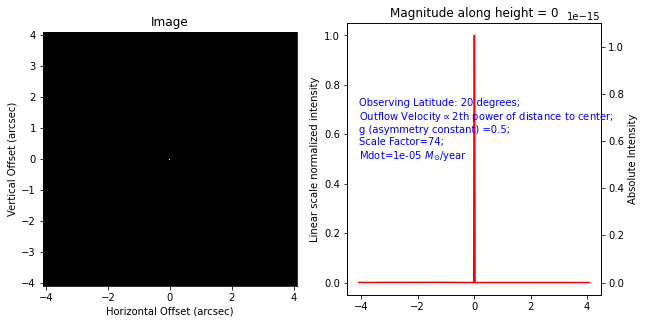

In [388]:
# 21 Plots
side_angular = np.linspace(-angularSize,angularSize,resolution+1)
X,Y = np.meshgrid(side_angular,side_angular)
np.seterr(divide='ignore')
fullValues = findValue(X,Y)

f = plt.figure(figsize=(10,5))
ax = f.add_subplot(121, aspect=1)

plt.xlabel("Horizontal Offset (arcsec)")
plt.ylabel("Vertical Offset (arcsec)")
plt.title("Image")
ax.pcolormesh(X,Y,fullValues,cmap='afmhot',shading='auto')
plt.gca().set_aspect('equal')
# plt.annotate('*', xy=(-0.080,-0.205), color = 'green', size = 20, label = 'star')
#ax.scatter(np.array([0]),np.array([0]),color = 'green', marker = 'x')
# fig, ax = plt.subplots()
# CS = ax.contour(X,Y,logFullValues)
# plt.gca().set_aspet('equal')

ax2 = f.add_subplot(122)
x_array = np.linspace(-angularSize,angularSize,resolution+1)
y_array = fullValues[int(resolution/2)]
normalizedYArray = y_array/np.max(np.nan_to_num(np.array(y_array, dtype=float)))
ax2.plot(x_array,normalizedYArray, color = 'red')
x_pos = (1+np.min(normalizedYArray))/2
ax2.set_ylabel("Linear scale normalized intensity")
plt.title("Magnitude along height = 0")

plt.annotate("Observing Latitude: "+str(observingLatitudeDegrees)+" degrees;\nOutflow Velocity"+r'$\propto$'+str(power)+"th power of distance to center;\n"+"g (asymmetry constant) ="+str(asymmetry_constant)+";\nScale Factor="+str(scale_factor)+";\nMdot="+str(Mdot_Solar_Mass)+" "+'$ M_{\odot}$'+"/year", xy=(-angularSize,x_pos), color = 'blue')

ax3=ax2.twinx()
ax3.plot(x_array,np.nan_to_num(np.array(y_array, dtype=float)), color = 'blue', alpha = 0)
ax3.set_ylabel("Absolute Intensity")

plt.show()

In [389]:
# 22 Saving Fits Files
modifiedValues = fullValues*1e16
hdul = fits.PrimaryHDU(data=modifiedValues)
now = datetime.now()
t_string = now.strftime("%m_%d_%Y_%Hh%Mm%Ss")
m_string = now.strftime("%m_%Y")
if os.path.exists("Desktop/Research/"+m_string)==False:
    os.makedirs("Desktop/Research/"+m_string)
string = "Desktop/Research/"+m_string+"/"+t_string+"_power_"+str(power)+"_multiplier_"+str(scale_factor)+"_1.fits"
hdul.writeto(string)

In [390]:
# 23 Image Convolution Kernel
kernel = Gaussian2DKernel(x_stddev=2/500*resolution,y_stddev=2/500*resolution)
astropy_conv = convolve(modifiedValues, kernel)

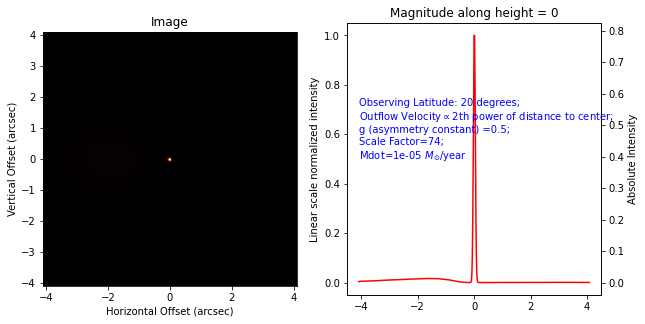

In [391]:
# 24 Plotting the Convoluted Image
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(121, aspect=1)

plt.xlabel("Horizontal Offset (arcsec)")
plt.ylabel("Vertical Offset (arcsec)")
plt.title("Image")
ax.pcolormesh(X,Y,astropy_conv,cmap='afmhot',shading='auto')
plt.gca().set_aspect('equal')
# plt.annotate('*', xy=(-0.080,-0.205), color = 'green', size = 20, label = 'star')
#ax.scatter(np.array([0]),np.array([0]),color = 'green', marker = 'x')
# fig, ax = plt.subplots()
# CS = ax.contour(X,Y,logFullValues)
# plt.gca().set_aspect('equal')

ax2 = f.add_subplot(122)
x_array = np.linspace(-angularSize,angularSize,resolution+1)
y_array = astropy_conv[int(resolution/2)]
normalizedYArray = y_array/np.max(np.nan_to_num(np.array(y_array, dtype=float)))
ax2.plot(x_array,normalizedYArray, color = 'red')
x_pos = (1+np.min(normalizedYArray))/2
ax2.set_ylabel("Linear scale normalized intensity")
plt.title("Magnitude along height = 0")

plt.annotate("Observing Latitude: "+str(observingLatitudeDegrees)+" degrees;\nOutflow Velocity"+r'$\propto$'+str(power)+"th power of distance to center;\n"+"g (asymmetry constant) ="+str(asymmetry_constant)+";\nScale Factor="+str(scale_factor)+";\nMdot="+str(Mdot_Solar_Mass)+" "+'$ M_{\odot}$'+"/year", xy=(-angularSize,x_pos), color = 'blue')

ax3=ax2.twinx()
ax3.plot(x_array,np.nan_to_num(np.array(y_array, dtype=float)), color = 'blue', alpha = 0)
ax3.set_ylabel("Absolute Intensity")

plt.show()

In [392]:
# 25 Saving Convoluted Files
hdul = fits.PrimaryHDU(data=astropy_conv)
string = "Desktop/Research/"+m_string+"/"+t_string+"_power_"+str(power)+"very very soft"+"_convolved.fits"
hdul.writeto(string)